# Adding (Not Yet)
>1. time steps: NF, NB in Backward / Forward \
Sizes of forwards and backwards memories in the BRNN. If you want a
standard feed-forward NN instead (no recursion, just a window) set to 0.
For a BRNN I imagine that the 20-30 range should be appropriate as a
starting point.

>2. Hidden units in Backward / Forward \
NHF,NHB:
Number of hidden units in the forwards and backwards memory networks.
This should typically be a little larger than NF,NB. For an FFNN set
both to 0 just like NF and NB.

>3. CoF, CoB \
Control the number of forwards and backwards memories that are seen by
the output network. These will be (2 x CoX + 1). For a BRNN 3-4 should
be OK. For a FFNN set both to 0.

## Option_BRNN file
epsilon 0.002 \
NLayers 1\
NU	21\
NHo	9\
NHt	20\
Ht	15\
NHi	15\
Hi	9

gamma	   7\
context 0

Classes 2\
Thresholds 0.5

DEEP	0

seed    949\
shuffle 1\
batch_blocks 1800\
readModel    0\
readEpoch    0\
nEpochs      5000\
adaptive     10000\
reload       1

# import 

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import random

import numpy as np

# processing bar
from tqdm import tqdm
# import hyperparameters
from cnn_hyperparams import *

# plots
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('CNN2.0board_test')

### device

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### logging

In [18]:
import logging
logging.root.setLevel(logging.INFO)
# logging.basicConfig(level=logging.NOTSET)
logging.basicConfig(filename=log_name+'_test', 
                    filemode='a',
                    format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %P',
                    level=logging.INFO)

# Load data

> Note: \
the reason not using tensor to save protein Sequences and Targets is we have varying length sequences! \
solve this problem we could consider pading. But our dataset lens range from about 20 to 10,000. Thus, padding is not a good idea here.

In [19]:
def load_dataset(fpath):
    num_protein = 0
    num_i = 0
    num_o = 0

    # p_names = []
    p_lens = []
    # p_seqs = []
    # p_anns = []
    p_data = []
    with open(fpath) as fp:
        num_protein = int(fp.readline())
        num_io = fp.readline().split(' ')
        num_i = int(num_io[0])
        num_o = int(num_io[0])

        line = fp.readline()
        while line:
            # p_name = line[:-1]
            p_len = int(fp.readline())
            p_sequence = torch.tensor([int(x) for x in fp.readline().split(' ')], 
                                      dtype=torch.float32).reshape(-1, 21)
            p_annotation = torch.tensor([int(x) for x in fp.readline().split(' ')], dtype=torch.float32)
            # skip empty
            next(fp)
            # p_names.append(p_name)
            p_lens.append(p_len)
            # p_seqs.append(p_sequence)
            # p_anns.append(p_annotation)
            p_data.append([p_sequence, p_annotation])
            line = fp.readline()    
    return p_data, p_lens

## train & test

In [20]:
train_data, train_plens = load_dataset(train_fpath)
test_data, test_plens = load_dataset(test_fpath)

In [21]:
train_data_ori = train_data.copy()
test_data_ori = test_data.copy()

train_data = train_data_ori[:15]
test_data = test_data_ori[:5]

In [22]:
# random.shuffle(p_data)
n_samples = len(train_plens)
# train_data = p_data[:int(n_samples*0.85)]
# test_data = p_data[int(n_samples*0.85):]

In [23]:
n_train = len(train_data)
n_test = len(test_data)

In [24]:
def get_num_class(input_data):
    c0 = 0
    c1 = 0
    for batch_idx, (data, target) in enumerate(input_data):
        c0 = c0 + len(target) - target.sum()
        c1 = c1 + target.sum()
    return c0, c1

In [25]:
train_c0, train_c1 = get_num_class(train_data)
test_c0, test_c1 = get_num_class(test_data)
print(f'train c0, c1: {train_c0}, {train_c1}')
print(f'test c0, c1: {test_c0}, {test_c1}')

train c0, c1: 6779.0, 514.0
test c0, c1: 3478.0, 292.0


### ROC curve

In [26]:
def rocPlot(train_label, train_probs, val_label, val_probs):
    fig = plt.figure(figsize=(12, 6))
    fpr, tpr, thresholds = roc_curve(train_label, train_probs)

    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 1)
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=model_name+" ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Training")
    plt.legend(loc="lower right")

    fpr, tpr, thresholds = roc_curve(val_label, val_probs)

    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=model_name+" ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Validation")
    plt.legend(loc="lower right")
    plt.show()
    return fig

## CNN
> kernel size = len*21


In [36]:
class CNN(nn.Module):
    def __init__(self, input_size, in_channels, kernel_size_row, 
                 kernel_size_col, num_classes):
        super(CNN, self).__init__()
        self.conv11 = nn.Conv2d(in_channels=1, out_channels=1, 
                               kernel_size=(15, 21),
                              stride = 1, padding=(7, 0))
        self.conv12 = nn.Conv2d(in_channels=1, out_channels=1, 
                               kernel_size=(15, 1),
                              stride = 1, padding=(7, 0))
        
#         self.conv12 = nn.Conv2d(in_channels=7, out_channels=1, 
#                                kernel_size=(3, 3),
#                               stride = 1, padding=(1, 1))
        
        self.conv5 = nn.Conv1d(in_channels=1, out_channels=1,
                              kernel_size=1, stride=1, 
                               padding=0)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.conv5(x.squeeze(3))
        x = self.sigmoid(x)
        # x = (x - x.min())/(x.max()-x.min())
        return x
    
    def train_batch(self, train_data, optimizer, criterion):
        # set training state to model
        self.to(device)
        self.train()
        with tqdm(total=num_batch, position=0) as progress_bar:
            for i in range(num_batch):
                # get current batch dataset
                bat_data = train_data[i*batch_size:min((i+1)*batch_size, n_samples)]
                bat_loss = 0
                for batch_idx, (data, target) in enumerate(bat_data):
                    data = data.to(device)
                    target = target.to(device)
                    # forward
                    scores = self(data.reshape(1, 1, data.shape[0], data.shape[1]))
                    loss = criterion(scores.squeeze(0).squeeze(0), target)

                    # ERROR
                    bat_loss = bat_loss + loss
                # backword
                optimizer.zero_grad()
                bat_loss.backward()
                #gradient descent or adam step
                optimizer.step()
                progress_bar.update(1)
                
    def val_batch(self, val_data, criterion): 
        # set evaluation state to the model
        self.to(device)
        self.eval()
        losses = []
        
        class_probs = []
        class_label = []
        
        # no gradient needed
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_data):
                data = data.to(device)
                target = target.to(device)
                # forward
                scores = self(data.reshape(1, 1, data.shape[0], data.shape[1]))
                loss = criterion(scores.squeeze(0).squeeze(0), target)
                # ERROR
                losses.append(loss.cpu()) # loss for each batch
                # save for ploting curve
                class_probs.append(scores.squeeze(0).squeeze(0).cpu())
                class_label.append(target.cpu())
                
        # overall loss
        loss = np.mean(losses)
        return loss, class_probs, class_label

# Initialize network

In [37]:
model = CNN(input_size, in_channels, kernel_size_row, 
                 kernel_size_col, num_classes)

In [38]:
# # 3 gates for GRU
# for name, param in model.named_parameters():
#     print(name)
#     print(param.size())
#     print(param)

# Loss and optimizer

In [39]:
dis_sum = 0 
for batch_idx, (data, target) in enumerate(train_data):
    dis_sum = dis_sum + target.sum()

In [40]:
class_weights = torch.tensor([dis_sum/sum(train_plens), 1-dis_sum/sum(train_plens)], dtype=torch.float)

# class_weights = torch.tensor([1, 18], dtype=torch.float)


In [41]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
class_weights

tensor([6.7862e-05, 9.9993e-01])

In [43]:
batch_size

2

# Train Network

epoch: 0


100%|█████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 130.21it/s]

Training: Loss:
0.43520775
VAL: Loss:
0.4590754


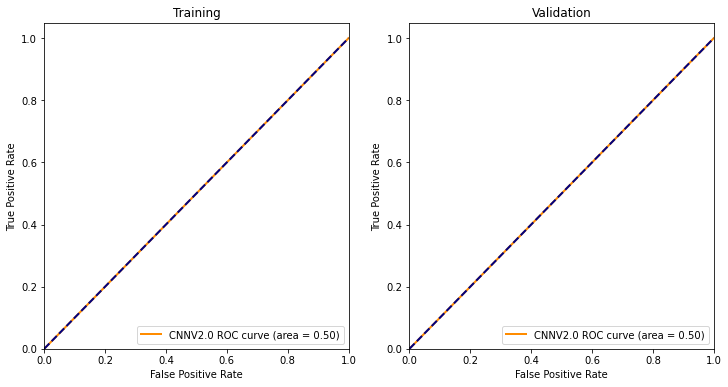

epoch: 1


100%|█████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 180.82it/s]

Training: Loss:
0.4336391
VAL: Loss:
0.45771417


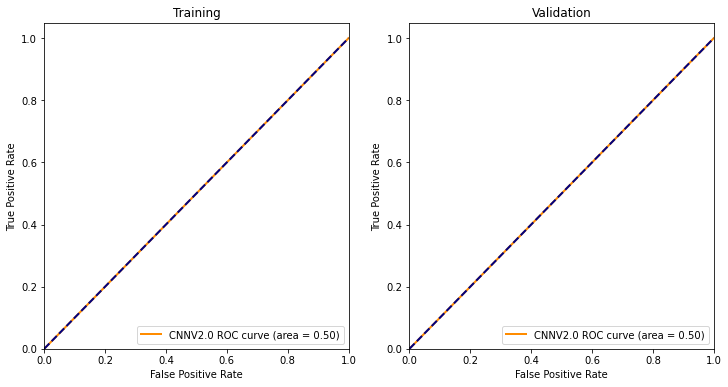

In [44]:
logging.warning(f"model_name: {model_name} \n \
                batch_size: {batch_size} \n \
                num_epochs: {num_epochs} \n \
                learning_rate: {learning_rate}")
'''
For each epoch:
    1. training
    2. calculate acc & loss for training dataset
    3. calculate acc & loss for val dataset
    4. add accs & losses to tensorboard
    5. finding the best val epoch
'''
batch_size = 2
# shuffled_data = p_data.copy()
num_batch = (n_train+batch_size-1)//batch_size

# val_loss = []
num_epochs = 2
plot_nEpoch = 1

for epoch in range(num_epochs):
    logging.warning('*********************************')
    logging.warning(f'epoch: {epoch}')
    logging.warning('*********************************')
    
    print(f'epoch: {epoch}')
    ################
    # 1. Training
    ################
    
    plot_pr_roc = (epoch % plot_nEpoch == 0)
    
    random.shuffle(train_data)
    # training
    model.train_batch(train_data, optimizer, criterion)
    
    # acc & loss
    train_loss, t_class_probs, t_class_label = model.val_batch(train_data, criterion)
    val_loss, v_class_probs, v_class_label = model.val_batch(test_data, criterion)
    # val_accs.append(val_acc)
    
    print('Training: Loss:')
    print(train_loss)
    
    print('VAL: Loss:')
    print(val_loss)
    
    logging.warning('Training:')
    logging.warning(f'Loss: {train_loss}')

    logging.warning('Validation:')
    logging.warning(f'Loss: {val_loss}')
    
    ##
    # for tensorboard plots
    ##
    writer.add_scalar("TRAIN: loss", train_loss, epoch)
    #writer.add_scalar("TRAIN: acc", train_acc, epoch)
    
    writer.add_scalar("VAL: loss", val_loss, epoch)
    #writer.add_scalar("VAL: acc", val_acc, epoch)
    
    ##
    # PR-curve & ROC-curve
    ##
    if plot_pr_roc:
        train_probs = torch.cat([batch for batch in t_class_probs])
        train_label = torch.cat(t_class_label)

        writer.add_pr_curve(f'TRAIN: pr_curve e{epoch}', train_label, train_probs, 0)

        val_probs = torch.cat([batch for batch in v_class_probs])
        val_label = torch.cat(v_class_label)

        writer.add_pr_curve(f'VAL: pr_curve e{epoch}', val_label, val_probs, 0)

        roc_fig = rocPlot(train_label, train_probs, val_label, val_probs)
        writer.add_figure(f'Train vs VAL: roc_curve e{epoch}', roc_fig)
    ##
    # Save model every m epochs
    ##
    if epoch % checkpoint_m == 0:
        cPATH = f"checkpoint/{model_name}_{epoch}.pth"
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': train_loss,
                    }, cPATH)
        
logging.warning(f"model_name: {model_name} \n \
                batch_size: {batch_size} \n \
                num_epochs: {num_epochs} \n \
                learning_rate: {learning_rate} \n ")
                # best_val_epoch: {int(np.argmax(val_accs)+1)}") # the best val epoch

writer.flush()
writer.close()

In [45]:
from torchsummary import summary
seq_len = 997
summary(model, (1, seq_len, 21))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 997, 1]             316
            Conv2d-2            [-1, 1, 997, 1]              16
            Conv1d-3               [-1, 1, 997]               2
           Sigmoid-4               [-1, 1, 997]               0
Total params: 334
Trainable params: 334
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


#### y.max(1) returns two tensors…

**1. the max value in each row of y** \
 0.7822\
 0.5563\
 0.9425\
**2. the column index at which the max value is found.**\
 3\
 3\
 0

## Save Model

In [ ]:
mPATH = '/home/dimeng/code_Di/python_code/test_model.pth'
torch.save(model.state_dict(), mPATH)

In [ ]:
cPATH = '/home/dimeng/code_Di/python_code/test_checkpoint.pth'
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, cPATH)

## Load Model

In [19]:
model = CNN(input_size, in_channels, kernel_size_row, 
                 kernel_size_col, num_classes)
model.load_state_dict(torch.load(mPATH))

<All keys matched successfully>

<bound method Module.parameters of CNN(
  (conv1): Conv2d(1, 21, kernel_size=(7, 21), stride=(1, 1), padding=(3, 0))
  (conv2): Conv1d(21, 21, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv3): Conv1d(21, 2, kernel_size=(7,), stride=(1,), padding=(3,))
)>